In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join('../src')))
from pyoma2.algorithms import FSDD, SSIcov, pLSCF
from pyoma2.setup.single import SingleSetup

In [11]:
data = pd.read_csv("Prueba.txt", sep='\t').to_numpy()

In [130]:
#n_accel = 7 # Number of sensors
#n_channel = 2 # Number of channels/sensor

In [131]:
#fig, axs = plt.subplots(n_accel, n_channel, figsize=(10, 10))
#z = 0
#for i in range(n_accel):
#  for j in range(n_channel):
#    ax = axs[i, j]
#    ax.plot(data[:, z])
#    z += 1
#
#fig.tight_layout()  # Ajusta el espaciado
#plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Ajusta el espaciado entre subplots
#
#plt.show()

In [8]:
frame_4P = SingleSetup(data, fs=250)

frame_4P.def_geo1_by_file("Geo1.xlsx")
frame_4P.def_geo2_by_file("Geo2.xlsx")

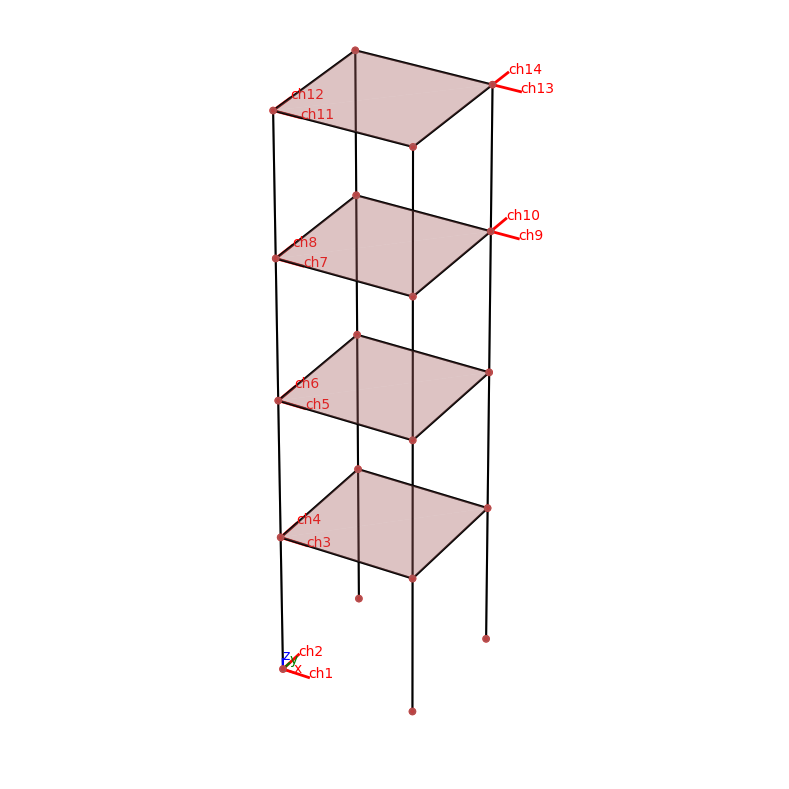

In [9]:
#_, _ = frame_4P.plot_geo1(scaleF=0.1)
_, _ = frame_4P.plot_geo2_mpl(scaleF=0.1)

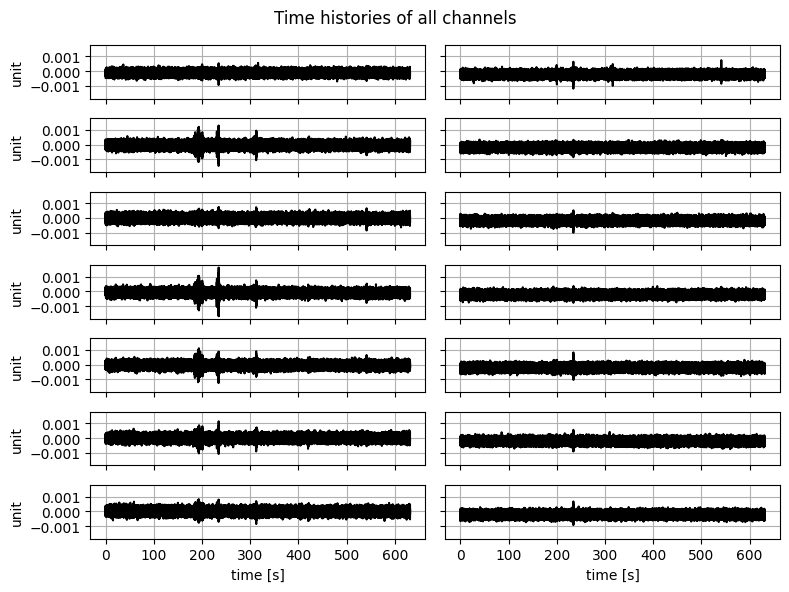

In [10]:
_, _ = frame_4P.plot_data(nc=2)

In [135]:
frame_4P.filter_data(Wn=(0.1, 25), order=8, btype="bandpass")
frame_4P.decimate_data(q=5)
#_, _ = frame_4P.plot_ch_info(ch_idx=[0])

In [ ]:
# Initialise the algorithms
fsdd = FSDD(name="FSDD", nxseg=1024, method_SD="cor")
ssicov = SSIcov(name="SSIcov", br=30, ordmax=30, calc_unc=True)
plscf = pLSCF(name="polymax",ordmax=30)

# Overwrite/update run parameters for an algorithm
fsdd.run_params = FSDD.RunParamCls(nxseg=1024, method_SD="per", pov=0.5)

# Add algorithms to the single setup class
frame_4P.add_algorithms(ssicov, fsdd, plscf)

# Run all or run by name
frame_4P.run_by_name("SSIcov")
frame_4P.run_by_name("FSDD")
frame_4P.run_by_name("polymax")
# frame_4P.run_all()

# save dict of results
ssi_res = ssicov.result.model_dump()
fsdd_res = dict(fsdd.result)

2025-03-18 16:30:44,376 - pyoma2.setup.base - INFO - Running SSIcov... (base:123)
2025-03-18 16:30:44,378 - pyoma2.functions.ssi - INFO - Assembling Hankel matrix method: cov... (ssi:82)
2025-03-18 16:30:44,483 - pyoma2.functions.ssi - INFO - ... calculating cov(H)... (ssi:93)
2025-03-18 16:30:45,297 - pyoma2.functions.ssi - INFO - SSI for increasing model order... (ssi:321)
100%|██████████| 31/31 [00:00<00:00, 9905.79it/s]
2025-03-18 16:30:45,423 - pyoma2.functions.ssi - INFO - ... propagating uncertainty... (ssi:448)
100%|██████████| 30/30 [00:20<00:00,  1.45it/s]
2025-03-18 16:31:06,084 - pyoma2.functions.ssi - INFO - Calculating modal parameters for increasing model order... (ssi:486)
100%|██████████| 31/31 [00:00<00:00, 73.52it/s] 
2025-03-18 16:31:06,562 - pyoma2.setup.base - INFO - Running FSDD... (base:123)
2025-03-18 16:31:06,747 - pyoma2.setup.base - INFO - Running polymax... (base:123)
100%|██████████| 30/30 [00:09<00:00,  3.29it/s]


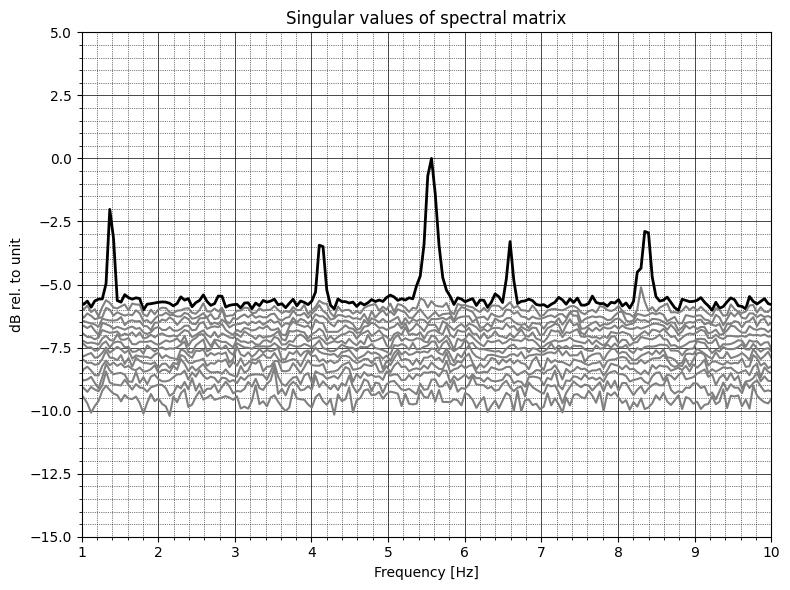

In [137]:
# plot Singular values of PSD
fig1, ax = fsdd.plot_CMIF()
ax.set_xlim(1, 10)
ax.set_ylim(-15, 5)
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

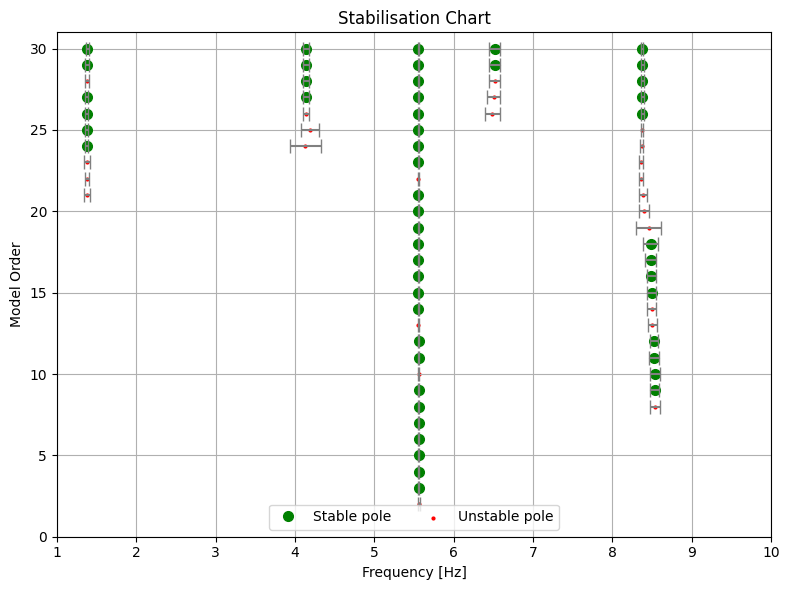

In [138]:
# plot Stabilisation chart for SSI
_, _ = ssicov.plot_stab(freqlim=(1,10), hide_poles=False)

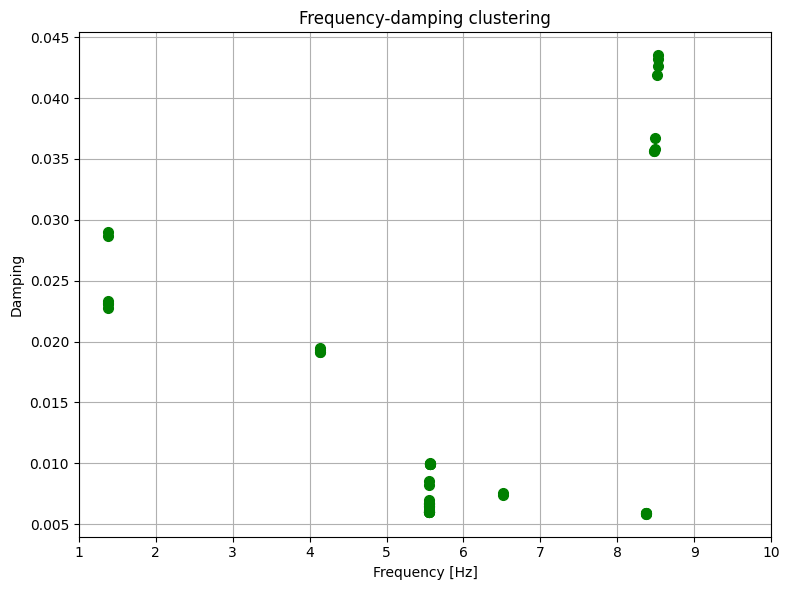

In [139]:
# plot frequecy-damping clusters for SSI
_, _ = ssicov.plot_freqvsdamp(freqlim=(1,10))

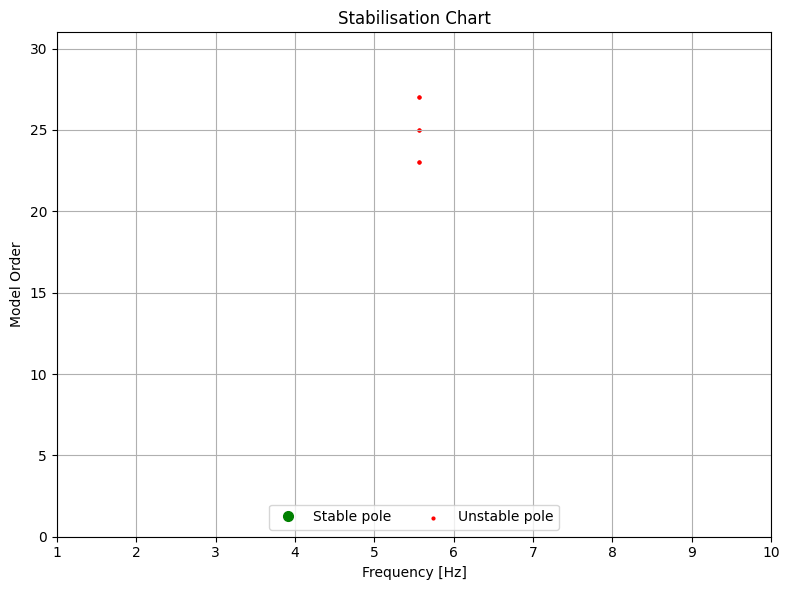

In [140]:
# plot Stabilisation chart for pLSCF
_, _ = plscf.plot_stab(freqlim=(1,10), hide_poles=False)

In [141]:
# Select modes to extract from plots
#frame_4P.mpe_from_plot("FSDD", freqlim=(0.5,15), MAClim=0.95)

# or directly
frame_4P.mpe("FSDD", sel_freq=[1.4, 4.1, 5.6, 6.6, 8.4], MAClim=0.95)

# update dict of results
fsdd_res = dict(fsdd.result)

2025-03-18 16:31:20,658 - pyoma2.setup.base - INFO - Getting mpe modal parameters from FSDD (base:149)
2025-03-18 16:31:20,687 - pyoma2.functions.fdd - INFO - Extracting FDD modal parameters (fdd:284)
100%|██████████| 5/5 [00:00<00:00, 21269.29it/s]
2025-03-18 16:31:20,691 - pyoma2.functions.fdd - INFO - Extracting EFDD modal parameters (fdd:492)
100%|██████████| 5/5 [00:00<00:00, 42.80it/s]


In [142]:
ssicov.result.Fn

In [143]:
fsdd.result.Fn

array([   1.37286383,    4.11844326,    5.54258236, -118.61111297,
          8.35289519])

([<Figure size 640x480 with 4 Axes>,
  <Figure size 640x480 with 4 Axes>,
  <Figure size 640x480 with 4 Axes>,
  <Figure size 640x480 with 4 Axes>,
  <Figure size 640x480 with 4 Axes>],
 [[<Axes: title={'center': 'SDOF Bell function'}, xlabel='Frequency [Hz]', ylabel='dB rel to unit.$'>,
   <Axes: title={'center': 'Auto-correlation Function'}, xlabel='Time lag[s]', ylabel='Normalized correlation'>,
   <Axes: title={'center': 'Portion for fit'}, xlabel='Time lag[s]', ylabel='Normalized correlation'>,
   <Axes: title={'center': 'Fit - Frequency and Damping'}, xlabel='counter $k^{th}$ extreme', ylabel='$2ln\\left(r_0/|r_k|\\right)$'>],
  [<Axes: title={'center': 'SDOF Bell function'}, xlabel='Frequency [Hz]', ylabel='dB rel to unit.$'>,
   <Axes: title={'center': 'Auto-correlation Function'}, xlabel='Time lag[s]', ylabel='Normalized correlation'>,
   <Axes: title={'center': 'Portion for fit'}, xlabel='Time lag[s]', ylabel='Normalized correlation'>,
   <Axes: title={'center': 'Fit - Freque

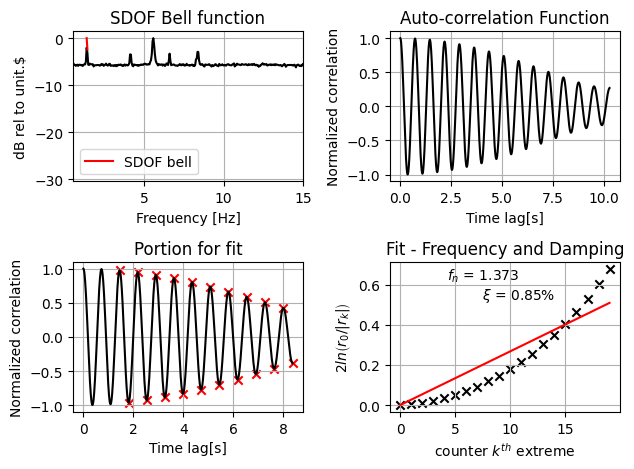

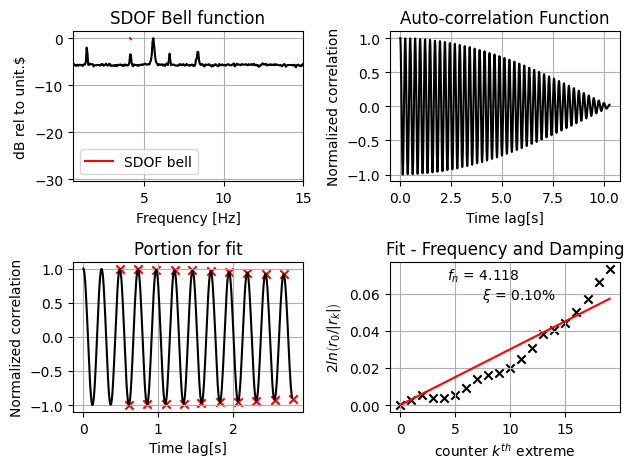

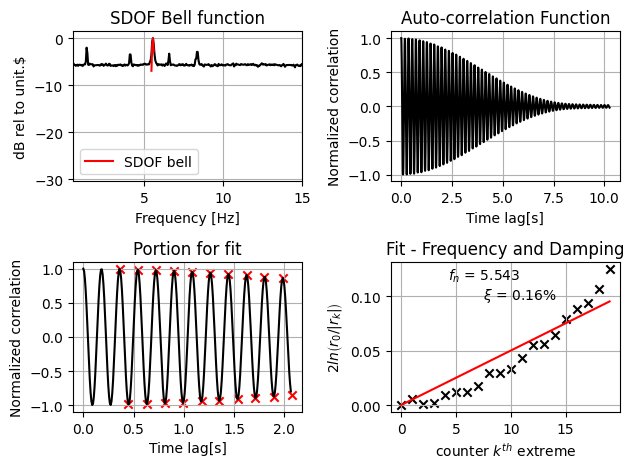

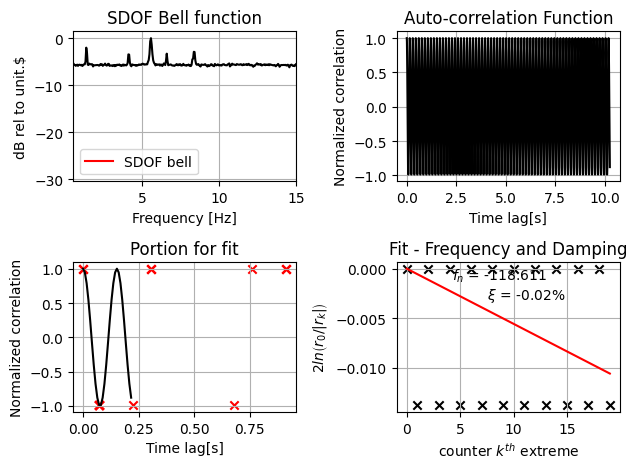

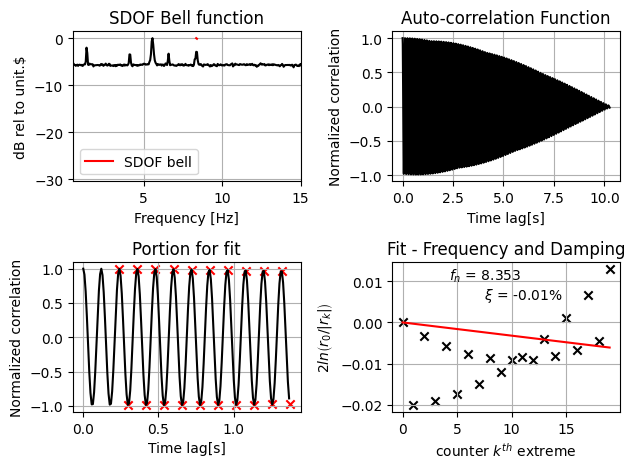

In [144]:
# plot additional info (goodness of fit) for EFDD or FSDD
frame_4P[fsdd.name].plot_EFDDfit(freqlim=(0.5,15))

In [145]:
# Mode shape plots
# Plot mode 1 (geometry 1)
print(frame_4P.geo2.sens_map)
frame_4P.plot_mode_geo2_mpl(algo_res=fsdd.result, mode_nr=1, view="3D", scaleF=0.5)
frame_4P.plot_mode_geo2_mpl(algo_res=fsdd.result, mode_nr=2, view="3D", scaleF=0.5)
frame_4P.plot_mode_geo2_mpl(algo_res=fsdd.result, mode_nr=3, view="3D", scaleF=0.5)
frame_4P.plot_mode_geo2_mpl(algo_res=fsdd.result, mode_nr=4, view="3D", scaleF=0.5)
frame_4P.plot_mode_geo2_mpl(algo_res=fsdd.result, mode_nr=5, view="3D", scaleF=0.5)

# Show the plot
plt.show()

         x       y  z
1      ch1     ch2  0
2        0       0  0
3        0       0  0
4        0       0  0
5      ch3     ch4  0
6   interp  interp  0
7   interp  interp  0
8   interp  interp  0
9      ch5     ch6  0
10  interp  interp  0
11  interp  interp  0
12  interp  interp  0
13     ch7     ch8  0
14  interp  interp  0
15     ch9    ch10  0
16  interp  interp  0
17    ch11    ch12  0
18  interp  interp  0
19    ch13    ch14  0
20  interp  interp  0


ValueError: could not convert string to float: 'interp'

In [ ]:
# Animate mode 1 (geometry 2)
#_ = frame_4P.anim_mode_geo2(algo_res=ssicov.result, mode_nr=1, scaleF=3)

In [ ]:
import os
import sys
import pathlib
# Add the directory we executed the script from to path:
sys.path.insert(0, os.path.realpath('__file__'))

from pyoma2.functions.gen import save_to_file, load_from_file

# Save setup
save_to_file(frame_4P, pathlib.Path(r"./test.pkl"))

